In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create some artificial data

In [19]:
n_datapoints = 30
noise_level = 0.3
test_input = 3

X = np.linspace(0, 2 * np.pi, n_datapoints)
true = np.sin(X)
y = true + np.random.normal(0, noise_level, n_datapoints)


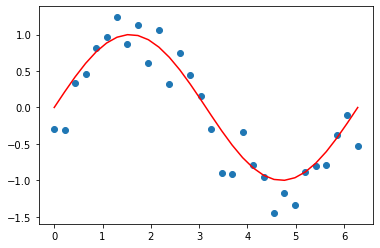

In [20]:
plt.scatter(X, y)
plt.plot(X, true, c='r')

# Define Covariance function

In [4]:
def rbf(x, x_prime, signal_var=1, len_scale=1, noise_var=0.1):
    return signal_var * np.exp(-(1/(2 * len_scale) * np.power(np.linalg.norm(x - x_prime), 2))) + noise_var

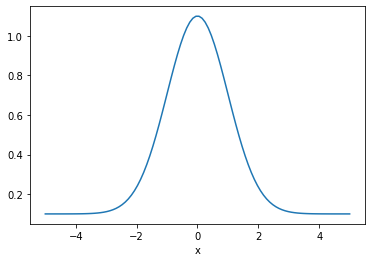

In [5]:
plt.plot(np.linspace(-5, 5, 100), [rbf(0, x) for x in np.linspace(-5, 5, 100)])
plt.xlabel('x')
plt.show()

In [6]:
def calculate_cov_matrix(X, k, signal_var=1, len_scale=1, noise_var=0.1):
    all_values = []
    
    for x_x in X:
        for x_y in X:
            all_values.append(k(x_x, x_y, signal_var, len_scale, noise_var))

    return np.array(all_values).reshape(len(X), len(X))

In [7]:
K = calculate_cov_matrix(X, k=rbf) 

# Gaussian Process regression

In [9]:
# Calculates the covariance between a test point and N training points (so gives a vector of N covariances)
def calculate_test_point_cov(test_input, X, k):
    k_star = []

    for train_point in X:
        k_star.append(k(test_input, train_point))

    return np.array(k_star)

In [10]:
def gaussian_process_regression(X, y, k, noise_level, test_input):
    k_star = calculate_test_point_cov(test_input, X, k)
    K = calculate_cov_matrix(X, k)
    
    L = np.linalg.cholesky(K + noise_level * np.identity(len(X))) # Calculate the upper Cholensky decomp
    transform_cholensky_y = np.linalg.solve(L, y) # Calculate the matrix transforming L decomp into y (Lx = y)
    a = np.linalg.solve(L.T, transform_cholensky_y) # Calculate the transform from L.T into the transformation of L into y
    
    # Calculate the function value and variance
    f_star = k_star.T @ a # For each transformation give the weight (distance from training example)
    v = np.linalg.solve(L, k_star)
    variance = k(test_input, test_input) - (v.T @ v)
    
    # Calculate the log posterior probability of y given X
    log_p = -(1/2 * (y.T @ a)) - np.log(np.diag(L)).sum() - ((len(X) / 2) * np.log(2 * np.pi)) # Log of gaussian
    
    return f_star, variance, log_p

# Predict the values over the same given interval

In [11]:
predicted_vals = []
predicted_vars = []
for val in np.linspace(0, 2 * np.pi, n_datapoints):
    mean, _, _ = gaussian_process_regression(X, y, rbf, noise_level, val)
    predicted_vals.append(mean)

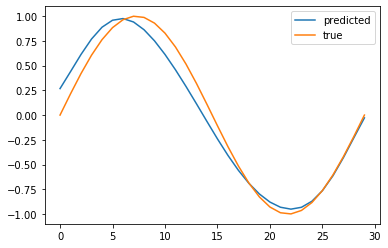

In [12]:
plt.plot(predicted_vals, label='predicted')
plt.plot(np.sin(X), label='true')
plt.legend()
plt.show()

# Exercises and Figures from chapter 2

In [407]:
import numpy as np
from scipy.stats import multivariate_normal

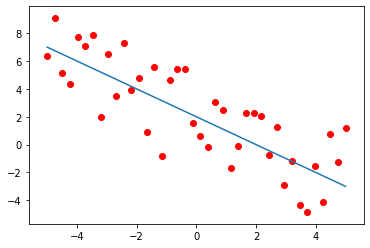

In [421]:
n_datapoints = 40
noise_level = 2

X = np.linspace(-5, 5, n_datapoints)
true = 2 + -1 * X # so we have a zero intercept and a slope of 3
y = true + np.random.normal(0, noise_level, n_datapoints)

plt.plot(X, true)
plt.scatter(X, y, c='r')

In [435]:
# Lets say that we assume that the prior probability is N(0, I) so a zero mean and a variance of 3

In [429]:
prior = multivariate_normal([0, 0], [3,3])

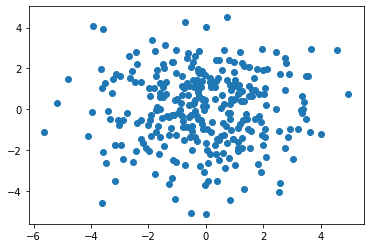

In [430]:
possible_combs = prior.rvs(300)
plt.scatter(possible_combs[:,0], possible_combs[:,1])

# Calculate the most likelihood of the possible combs that we have

In [431]:
design_matrix = np.concatenate([np.ones((1, X.shape[0])), X.reshape(1, X.shape[0])], axis=0)

In [438]:
likelihoods = []

for w in possible_combs:
    w = w.reshape(2, 1)
    likelihoods.append(multivariate_normal((design_matrix.T @ w).flatten(), noise_level * np.eye(X.shape[0])).pdf(y.reshape(1, -1)))

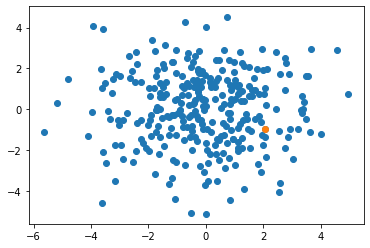

In [439]:
plt.scatter(possible_combs[:,0], possible_combs[:,1])
plt.scatter(possible_combs[np.argsort(likelihoods)[-1],0], possible_combs[np.argsort(likelihoods)[-1],1])


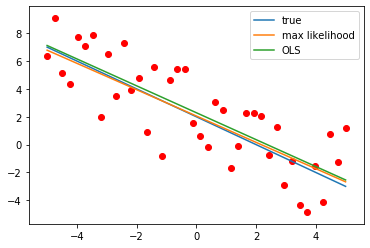

In [440]:
n_datapoints = 40
noise_level = 3

X = np.linspace(-5, 5, n_datapoints)
true = 2 + -1 * X # so we have a zero intercept and a slope of 3

coef_mle = possible_combs[np.argsort(likelihoods)[-1]]
pred_mle = coef_mle[0] + coef_mle[1] * X
ols_coef = (np.linalg.inv(design_matrix @ design_matrix.T) @ design_matrix) @ y
ols_pred = ols_coef[0] + ols_coef[1] * X


plt.plot(X, true, label='true')
plt.plot(X, pred_mle, label='max likelihood')
plt.plot(X, ols_pred, label='OLS')
plt.scatter(X, y, c='r')
plt.legend()